## Submission instruction 

1. For part 1, the notebook will generate python files in submission. The submission folder will need to be
uploaded to the course website.
2. While solving the assignment, do **NOT change class and method names**, autograder tests will fail
otherwise. However, you can add utility functions into base class if needed.
3. You'll also have to upload a **PDF version** of the notebook (which would be primarily used to grade your
report section of the notebook).
4. Deadline: **2022.12.16 23:00**

Put the `submission` folder, 1 pdf exported from this notebook into one folder with name **student id_student name** , zip the folder and upload the course website (the teaching cube).

## Part1. Phoneme classification (70 points)

### I. Overview

This assignment includes two parts: **Phoneme classification (70 points)** and **Connectionist Temporal Classification (CTC) loss (30 points + 15 points for bonus)**. In the part 1, you are asked to classify audio segments into 7 phoneme classes (VS, NF, SF, WF, ST, CL and q for glotal ).

In this part, you are asked to classify audio segments into 7 phoneme classes (VS, NF, SF, WF, ST, CL and q for glotal ). The meaning of those classes (except q) is given in the following table.


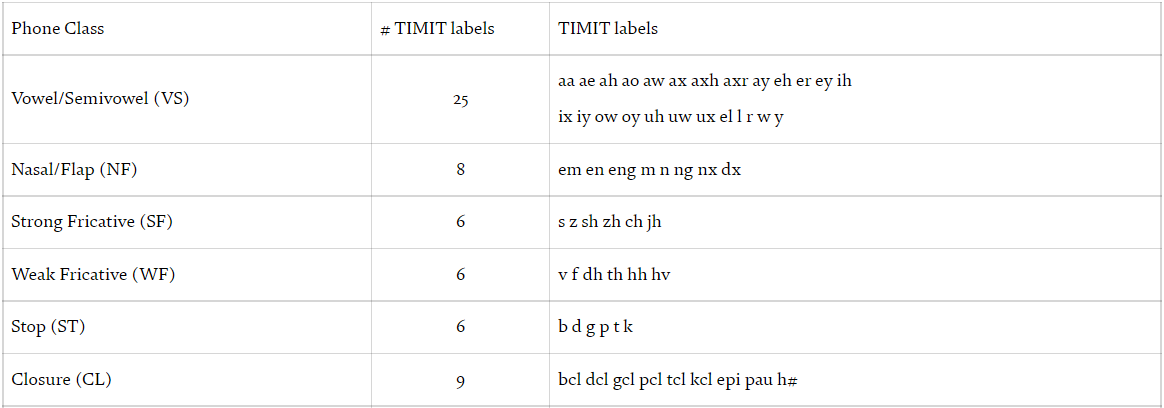

This assignment contains three tasks:

    - Task 1: Data Preparation and Feature extraction (20 points)
    - Task 2: A simple frame-based classification (35 points)
    - Task 3: Written report (15 points)

For Task 1, you are asked to use librosa to extract MFCC features from wavfiles. 

For Task 2, you are given a training dataset and a validation set in the folder audio/part-1. Your method will be evaluated on a hidden test set. Students who can achive results better than our  **simple baseline(Frame-based Accuracy 0.49，Segment-based Accuracy 0.43 )** can get maximum score of task 1.

For Task 3, you are asked to report your experimental results.

### II. Setup


In [1]:
%load_ext autoreload
%autoreload 2

`submission` contains all the files that you will submit; output contains the output files of your model

In [2]:
import os
try: 
    os.mkdir('submission')
except FileExistsError:
    pass
try:
   open('submission/__init__.py', 'x')
except FileExistsError:
   pass
try: 
    os.mkdir('output')
except FileExistsError:
    pass

### III. Data Preprocessing and Feature Extraction (20 points)


In [35]:
%%writefile submission/features.py 
import glob
import pickle
import librosa
import scipy
import numpy as np
from tqdm import tqdm
from collections import Counter
from sklearn import preprocessing

def wavfile_to_mfccs(wavfile):
    """
    Returns a matrix of shape (nframes, 39), since there are 39 MFCCs (deltas
    included for each 20ms frame in the wavfile).
    """
    x, sampling_rate = librosa.load(wavfile)

    window_duration_ms = 20
    n_fft = int((window_duration_ms / 1000.) * sampling_rate)

    hop_duration_ms = 10
    hop_length = int((hop_duration_ms / 1000.) * sampling_rate)

    mfcc_count = 13

    #### BEGIN YOUR CODE  (5 points)
    # Call librosa.feature.mfcc to get mfcc features for each frame of 20ms
    # Call librosa.feature.delta on the mfccs to get mfcc_delta
    # Call librosa.feature.delta with order 2 on the mfccs to get mfcc_delta2
    # Stack all of them (mfcc, mfcc_delta, mfcc_delta2) together 
    # to get the matrix mfccs_and_deltas of size (#frames, 39)
    mfcc = librosa.feature.mfcc(y=x, sr=sampling_rate, n_mfcc=mfcc_count, n_fft=n_fft, hop_length=hop_length)
    mfcc_delta1 = librosa.feature.delta(mfcc, order=1)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    mfccs_and_deltas = np.vstack([mfcc,mfcc_delta1,mfcc_delta2])
    mfccs_and_deltas = mfccs_and_deltas.transpose(1,0)
    #### END YOUR CODE

    return mfccs_and_deltas, hop_length, n_fft

class ShortTimeAnalysis:
    def __init__(self):
        pass
    
    def perform(self, wavfile):
        pass
    
class MFCCAnalysis(ShortTimeAnalysis):
    def perform(self, wavfile):
        return wavfile_to_mfccs(wavfile)


Overwriting submission/features.py


In [5]:
import sys

In [6]:
print(sys.executable)

d:\softwares\anaconda3\envs\introRL\python.exe


In [7]:
import librosa

In [8]:
# Testing your method
wavfile = "audio/part-1/train/SA1.WAV"

X, hop_lengt, window_len = wavfile_to_mfccs(wavfile)
print (X.shape)

(394, 39)


In [36]:
%%writefile submission/dataset.py 

import glob
import pickle
import librosa
import scipy
import numpy as np
from tqdm import tqdm
from collections import Counter
from sklearn import preprocessing
import ipdb

unique_classes = ['CL', 'SF', 'VS', 'WF', 'ST', 'NF', "q"]

def read_data_folder(data_path):
    """
    @return
    wav_files: list of file paths to WAV files in the train or val folder.
    labels_files: ist of file paths to PHNCLS files in the train or val folder.
    """
    # get all the WAV and PHNCLS in the folder data_path
    wav_files = sorted(glob.glob(data_path + "/*.WAV"))
    labels_files = sorted(glob.glob(data_path + "/*.PHNCLS"))
    return wav_files, labels_files

# 提取segment labels和representations
def extract_features(wavfile, label_file, first_seg_id=0, stanalysis=MFCCAnalysis()):
    """
    Extract segment labels and representations.
    
    @arguments:
    wavfile: path to wav file
    label_file: path to PHNCLS file
    first_seg_id: segment_id of the first segment of the current file.
                  When you process a list of files, you may want segment id to increase globally.

    @returns:
    X: #frames, #features
    y: #frames

    frame2seg: mapping from frame id to segment id
    y_seg: segment labels (segment-based groundtruth)
    """
    #  mfccs_and_deltas, hop_length, n_fft    
    X_st, hop_length, window_len = stanalysis.perform(wavfile)
    # print(hop_length, window_len) # 220 441

    seg_labels = {}
    point_seg_ids = []
    with open(label_file, 'r') as f:
        for line in f.readlines():
            start_frame, end_frame, label = line.split(' ')
            start_frame = int(start_frame)
            end_frame = int(end_frame)
            
            label = label.strip()
            segment_id = len(seg_labels) + first_seg_id
            seg_labels[segment_id] = label
            
            phn_frames = end_frame - start_frame
            # point_seg_ids stores segment ids for every sample point.
            point_seg_ids.extend([segment_id]*phn_frames) 
            

    X = []
    y = []
    frame_seg_ids = []
    curr_frame = curr_hop = 0
    
    while (curr_frame < (len(point_seg_ids) - window_len)):
        ### BEGIN YOUR CODE (10 points)
        
        # extract the segment ids for the sample points within the frame 
        # from curr_frame to curr_frame + window_len
        
        # Since one frame may overlap with more than one segment, 
        # sample points within the frame may be assigned with multiple segment ids.
        # We get the major segment id as the segment id corresponding to the current frame.
        # 主元素问题，采用摩尔投票算法，时间复杂度为 O(n)
        count = 0
        for i in range(curr_frame, curr_frame + window_len):
            if count:
                if point_seg_ids[i] == major:
                    count += 1
                else:
                    count -= 1
            else:
                major = point_seg_ids[i]
                count += 1
        segment_id = major
        ### END YOUR CODE

        label = seg_labels[segment_id]
        y.append(label)
        X.append(X_st[curr_hop,:])
        frame_seg_ids.append(segment_id)
        
        curr_hop += 1
        curr_frame += hop_length
    
    return X, y, frame_seg_ids, seg_labels


def prepare_data(wavfiles, label_files, stanalysis=MFCCAnalysis()):
    X = []
    y = []
    segment_ids = []
    seg2labels = {}
    
    file_seg_id = 0
    for i in tqdm(range(len(wavfiles))):
        wavfile = wavfiles[i]
        label_file = label_files[i]
        x_, y_, seg_ids_, seg_labels_ = extract_features(
            wavfile, label_file, first_seg_id=file_seg_id, stanalysis=stanalysis)

        file_seg_id += len(seg_labels_)
        for k,v in seg_labels_.items():
            seg2labels[k] = v

        X.append(x_)
        y.extend(y_)
        segment_ids.extend(seg_ids_)
        

    X = np.concatenate(X)
    return X, y, segment_ids, seg2labels

Overwriting submission/dataset.py


In [11]:
# Testing 
wavfiles, label_files = read_data_folder("audio/part-1/train/")
X, y, segment_ids, seg2labels = prepare_data(wavfiles[0:1], label_files[0:1])
print (X.shape) # 284 39

100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

(284, 39)


In [37]:
%%writefile submission/preprocessing.py
from sklearn import preprocessing
import numpy as np

# Training data Zero-centered 
def normalize_mean(X):
    """
    Using scikit learn preprocessing to transform feature matrix
    using StandardScaler with mean and standard deviation
    """
    ### BEGIN YOUR CODE (3 points)
    scaler = preprocessing.StandardScaler(with_std=False)
    X = scaler.fit_transform(X)
    ### END YOUR CODE
    return X, scaler.mean_

# Test data Zero-centered
def apply_normalize_mean(X, scaler_mean):
    """
    Apply normalizaton to a testing dataset that have been fit using training dataset.
    
    @arguments:
    X: #frames, #features (in case we use mfcc, #features is 39)
    scaler_mean: mean of fitted StandardScaler that you used in normalize_mean function.
    
    @returns:
    X: normalized matrix
    """ 
    ### BEGIN YOUR CODE (2 points)
    X = X - scaler_mean
    # X = X / scaler_std
    ### END YOUR CODE
    return X


Overwriting submission/preprocessing.py


In [14]:
# Testing
X, scaler_mean = normalize_mean(X)

### IV. Phone Classifier (35 points)

In this part, we will perform isolated phone classification. We assume that phones are well segmented. This section includes two tasks: phone classifier with MFCC, and building your best model.

In [38]:
%%writefile submission/model.py

import time,datetime
import numpy as np
from collections import Counter
import torch
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
from torch.nn import Sequential
import torch.nn.functional as F
from torch.utils.data import TensorDataset,DataLoader

def onehot_matrix(samples_vec, num_classes):
    """
    >>> onehot_matrix(np.array([1, 0, 3]), 4)
    [[ 0.  1.  0.  0.]
     [ 1.  0.  0.  0.]
     [ 0.  0.  0.  1.]]

    >>> onehot_matrix(np.array([2, 2, 0]), 3)
    [[ 0.  0.  1.]
     [ 0.  0.  1.]
     [ 1.  0.  0.]]

    Ref: http://bit.ly/1VSKbuc
    """
    num_samples = samples_vec.shape[0]

    onehot = np.zeros(shape=(num_samples, num_classes))
    onehot[range(0, num_samples), samples_vec] = 1

    return onehot

def segment_based_evaluation(y_pred, segment_ids, segment2label):
    """
    @argments:
    y_pred: predicted labels of frames
    segment_ids: segment id of frames
    segment2label: mapping from segment id to label
    """
    seg_pred = {}
    for frame_id, seg_id in enumerate(segment_ids):
        if seg_id not in seg_pred:
            seg_pred[seg_id] = []
        seg_pred[seg_id].append(y_pred[frame_id])

    ncorrect = 0
    for seg_id in seg_pred.keys():
        predicted = seg_pred[seg_id]
        c = Counter(predicted)
        predicted_label = c.most_common()[0][0] # take the majority voting

        if predicted_label == segment2label[seg_id]:
            ncorrect += 1

    accuracy = ncorrect/len(segment2label)
    print('Segment-based Accuracy using %d testing samples: %f' % (len(segment2label), accuracy))

device = ('cuda:2' if torch.cuda.is_available() else 'cpu')

class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        ### BEGIN YOUR CODE (10 points)
        # 特征维度、隐层神经元、
        self.lstm = nn.LSTM(input_size=1, hidden_size=32, num_layers=1, bidirectional=True, batch_first=True)
        self.fc = Sequential(
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=32*2, out_features=32), # 双向LSTM
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=32, out_features=7)
        )
        ### END YOUR CODE

    def get_optimizer(self):
        ### BEGIN YOUR CODE (5 points)
        optimizer = torch.optim.Adam(self.parameters(), lr = 1e-2)
        torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0) # T_max表示周期的1/2 eta_min表示学习率变化的最小值
        ### END YOUR CODE
        return optimizer
    
    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:,-1,:] # 最后一个时刻的结果
        x = self.fc(x)
        return x
    

class PhonemeClassifier(object):
    def __init__(self):
        unique_phonemes = ['CL', 'SF', 'VS', 'WF', 'ST', 'NF', "q"]
        self.labels = unique_phonemes
        self.train_epoch = 20

    def label_to_ids(self, y):
        y_ = [self.labels.index(label) for label in y]
        return y_

    def id_to_label(self, y):
        y_ = [self.labels[i] for i in y]
        return y_

    
    def train(self, X_train, y_train):
        y_train = self.label_to_ids(y_train)
        y_train = np.asarray(y_train)
        
        ### BEGIN YOUR CODE (15 points)
        X_train = torch.from_numpy(X_train).float().reshape((-1, 39, 1))
        y_train = torch.Tensor(y_train).long()
        
        dataset = TensorDataset(X_train, y_train)
        dataset = DataLoader(dataset, batch_size=4096, shuffle=True)
        
        self.model = Model()
        self.model = self.model.to(device)
        loss_fn = nn.CrossEntropyLoss()
        self.optimizer = self.model.get_optimizer()
        self.model.train()
        for epoch in range(self.train_epoch):
            total_loss = 0
            for data in dataset:
                x, y = data
                x, y = x.to(device), y.to(device)
                y_pred = self.model(x)
                loss = loss_fn(y_pred, y)
                total_loss += loss
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
        ### END YOUR CODE

    def test(self, X_test, y_test):
        """
        @arguments:
        X_test: #frames, #features (39 for mfcc)
        y_test: frame labels
        """
        ### BEGIN YOUR CODE (5 points)
        X_test = torch.from_numpy(X_test).float().reshape((-1, 39, 1))
        X_test = X_test.to(device)
        self.model.eval()
        label_pred = self.model(X_test)
        out_classes = torch.argmax(label_pred, axis=1)
        ### END YOUR CODE
        
        out_classes = self.id_to_label(out_classes) # from id to string
        out_classes = np.asarray(out_classes)
        acc = sum(out_classes == y_test) * 1.0 / len(out_classes)
        print('Frame-based Accuracy using %d testing samples: %f' % (X_test.shape[0], acc))

        return out_classes

Overwriting submission/model.py


In [18]:
from submission import model

wav_files, label_files = read_data_folder("audio/part-1/train")
X_train, y_train, _, _  = prepare_data(wav_files, label_files)

X_train, scaler_mean = normalize_mean(X_train)
    
wav_files, label_files = read_data_folder("audio/part-1/val")
print (len(wav_files), len(label_files))
X_test, y_test, test_seg_ids, test_seg2labels  = prepare_data(
        wav_files, label_files)
X_test = apply_normalize_mean(X_test, scaler_mean)

cls = model.PhonemeClassifier()
cls.train(X_train, y_train)
y_pred = cls.test(X_test, y_test)

model.segment_based_evaluation(y_pred, test_seg_ids, test_seg2labels)

Frame-based Accuracy using 19424 testing samples: 0.508701
Segment-based Accuracy using 3324 testing samples: 0.448857


### V. Written Report (15%)


#### Question 1 (10%):

Describe your classification model.

**Answer**

In this experiment, I use BiLSTM + MLP as the final model. Since I convert the input into data with shape (batch_size, 39, 1), so the BiLSTM model is with 1 feature dimension, 39 sequence dimension, 32 hidden layer neurons. 

The results of the last timestamp after the BiLSTM model are inputted into the MLP model, and the MLP model have bilinear layers in shape [64 x 32], [32 x 7]. In addition, the ReLU activation function is used to improve the nonlinear expression ability, and Dropout method can prevent the model from overfitting. 

Regarding the optimization function, I used the Adam optimization function and the cosine annealing learning rate, where the initial learning rate is set to 1e-2, the period is 10 epoches and the learning rate minimum is set to 0.

I have tried using only LSTM or just CNN, but the results are not very good. Also I have tried modifying the number of hidden layers in LSTM and MLP or changing the optimization function, but it has little effect on the result. Besizes, I want to use the LSTM + CRF model, the CRF layer can obtain the relationship between the labels and add some constraints to ensure final result is valid, but it is too complex to realize code. So I finally use the following BiLSTM + MLP model, and it acheives a pretty good result in validation dataset.


#### Question 2 (5%)
What is the best performance that you can get with MFCC on the validation set?

**Answer**

Frame-based Accuracy: 0.508701

Segment-based Accuracy: 0.448857

I have tried using only LSTM or just CNN, but the results are not very good. Also I have tried modifying the number of hidden layers in LSTM and MLP or changing the optimization function, but it has little effect on the result. Besizes, I want to use the LSTM + CRF model, the CRF layer can obtain the relationship between the labels and add some constraints to ensure final result is valid, but it is too complex to realize code. So I finally use the following BiLSTM + MLP model, and it acheives a pretty good result in validation dataset.



-------

## Part 2: Implementing CTC Loss (45 points)

 We introduce the Connectionist Temporal Classification (CTC) objective, which is a popular objective used to train neural networks to do speech recognition. Critically, it does not require you to know the alignments between inputs and outputs.

### **Summary of CTC**

We highlight some of the main features of the CTC objective.

- Given a sequence of inputs `x_1, x_2, .., x_T`, an ASR model will map each of these to a probability of an alphabet of C tokens: `p_1, p_2, ..., p_T`. For example, if we are decoding to three possible characters, the probabilities for timestep `t` could look like `p_t = [0.3, 0.2, 0.5]`.

- We also have a sequence of symbol targets `y_1, y_2, ..., y_S` (note `S <= T`). Each `y_s` is a number from `0` to `C-1` (e.g. one of the characters).

- The main strategy is to decode each `x_t` to a predicted character `y'_t`. For example, `x_1, x_2, ..., x_6 -> c c a a a t`. This mapping is called an **alignment**. Then we can collapse repetitions to get `c a t` as the predicted output sequence. This simple strategy has some problems: how do you handle silences or repeated characters?

- CTC adds a special `blank` token. We'll call this `eps`. Now consider this example, `x_1, x_2, ..., x_12 -> h h e eps eps l l l eps l l o`. Now we can collapse everything in between each `eps` to get `h e eps l eps l o`. Removing blank tokens, we get the prediction `hello`.

- For an output sequence, there are many "valid" alignments. For example, given an input sequence `x_1, ..., x_6` and an output sequence `c a t`, valid alignments include `eps c c eps a t`, `c c a a t t`, or `c a eps eps eps t`. Example of invalid alignments include `c eps c eps a t`, `c c a a t` (too short if the input sequence has 6 tokens), and `c eps eps eps t t`.

- Let `A` represent all valid alignments of an output sequence to an input sequence. A simplified pseudocode for the CTC objective might look like:

```
all_log_prob = 0

for each (a_1, a_2, ..., a_S) in A:

    log_prob = 0

    for t in 1 to T:
        # The alignment a_s has a specific output character for input position t
        log_prob_t = log p(a_(s,t) | x_1, ..., x_T)
        # compute the joint probability by multiplying independent time steps
        # Adding in log space to avoid underflow
        log_prob += log_prob_t

    all_log_prob += log_prob
```
That is, the CTC loss computes the probability of all possible alignments. Please note that the pseudocode above is for intuition. In practice, it is often too slow to enumerate over `A` explicitly. 

As an example, for an output sequence of length 50 (without any repeated characters) and an input sequence of length 100, the number of unique alignments is almost 10^40. 



### Task 1.1 CTC Objective (20 Points)
Please write a function in PyTorch that given a minibatch of model predicted probabilities and a minibatch of output sequences, computes the CTC objective.

**Note:** You cannot use the built-in `F.ctc_loss` in PyTorch.

In [19]:
#@title Import packages
import nltk
import os
# nltk.download('punkt')
from nltk.tokenize import word_tokenize

import json
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import matplotlib.pyplot as plt
from typing import Tuple

FIX_SEED = 39

In [21]:
def ctc_loss(
    log_probs: torch.FloatTensor, targets: torch.LongTensor,
    input_lengths: torch.LongTensor, target_lengths: torch.LongTensor,
    blank: int = 0) -> torch.Tensor:
  """
  Connectionist Temporal Classification implementation.
  
  Args:
    log_probs: The log-beliefs returned by an ASR model.
      This is `log p(a_t | x_1, ..., x_T)`.
      (Shape: T x batch_size x C, where T is a maximum input sequence length and
      C is the alphabet size (including blank))

    targets: Sequence of contiguous output labels (no blanks).
      This is `y_1, ..., y_S`.
      (Shape: batch_size x S, where S is a maximum output sequence length)

    input_lengths: Lengths of each example in minibatch (<= T).
      (Shape: batch_size)

    target_lengths: Lengths of each target in minibatch (<= S).
      (Shape: batch_size)

    blank: The "epsilon" token that is used to represent silence.
      (integer <= C, default 0)

  Returns:
    CTC loss averaged over minibatch.
  """
  #############################
  #### YOUR CODE GOES HERE ####
  losses = []
  log_probs = torch.exp(log_probs)
  T, C = log_probs.shape[0], log_probs.shape[-1]
  
  for i, target in enumerate(targets):
    L = 2 * target_lengths[i] + 1

    # 动态规划算法
    alphas = torch.zeros((L, T))
    alphas[0, 0] = log_probs[0, i, blank] # 初始化，只有两个值非零
    alphas[1, 0] = log_probs[0, i, target[0]]
    c = torch.sum(alphas[:, 0])
    alphas[:, 0] /= c
    loss = torch.log(c)

    for t in range(1, T):
      start = max(0, L - 2 * (T - t))
      for s in range(start, L):
        l = (s - 1) // 2
        if s % 2 == 0: # s为blank
            if s == 0:
                alphas[s, t] = alphas[s, t - 1] * log_probs[t, i, blank]
            else:
                alphas[s, t] = (alphas[s, t - 1] + alphas[s - 1, t - 1]) * log_probs[t, i, blank]
        elif s == 1 or target[l] == target[l - 1]: # l是s所对应的字符,l-1是s-2对应的字符
            alphas[s, t] = (alphas[s, t - 1] + alphas[s - 1, t - 1]) * log_probs[t, i, target[l]]
        else:
            alphas[s, t] = (alphas[s, t - 1] + alphas[s - 1, t - 1] + alphas[s - 2, t - 1]) * log_probs[t, i, target[l]]

      c = torch.sum(alphas[:, t])
      alphas[:, t] = alphas[:, t] / c
      loss += torch.log(c) # 每个时间步独立，因此概率相乘
    losses.append(-loss)
  return torch.mean(torch.stack(losses))
  #############################
  

Here is a good sanity check. Test you code by checking below that `test` and `soln` are roughly equal. It's okay if your solution is much slower since the Pytorch one is coded in C. However, we will deduct points if you enumerate over all alignments as this is too slow for practical use.



In [25]:
import torch
import torch.nn.functional as F

log_probs = torch.randn(50, 16, 20).log_softmax(2).detach().requires_grad_() # shape [50, 16, 20] 20个单词 
targets = torch.randint(1, 20, (16, 30), dtype=torch.long) # shape [16, 30] 30
input_lengths = torch.full((16,), 50, dtype=torch.long) # tensor([50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]) # 输入序列长度
target_lengths = torch.randint(10,30,(16,), dtype=torch.long) # tensor([15, 16, 10, 21, 23, 12, 16, 22, 22, 25, 28, 22, 15, 20, 28, 22]) # 输出序列长度

est = ctc_loss(log_probs, targets, input_lengths, target_lengths, blank=0)
soln = torch.mean(F.ctc_loss(log_probs, targets, input_lengths, target_lengths, blank=0, reduction='none'))

print(est.detach().numpy(), soln.detach().numpy())

114.021225 114.021225


### Task 1.2 Demonstrate your implementation (10 points)

Print your loss function results on the log_probs and targets we provide. You can load the test minibatches by calling `get_test_minibatches()`.

In [26]:
import torch
import torch.nn.functional as F
import random

def get_test_minibatches() -> list:
  """Get minibatches to test implementation
  Returns:
    lists of log_probs, targets, input_lengths, target_lengths
  """
  torch.manual_seed(FIX_SEED)
  np.random.seed(FIX_SEED)
  random.seed(FIX_SEED)

  T = np.array([])
  C = np.array([])
  N = np.array([])  
  S = 40  # Target sequence length of longest target in batch (padding length) # 最大输出长度
  for i in range(10):
    T = np.append(T, random.randint(i+50, i+80)) # 输入最大长度
    C = np.append(C, random.randint(int(0.4* T[i]), int(0.8*T[i]))) # 词汇表
    N = np.append(N, random.randint(int(0.7 *C[i]), int(0.9*C[i]))) # batch_size
      
  log_probs = []
  input_lengths = []
  target_lengths = [] # 10 x N[i]
  targets = []
  for i in range(10):
    log_probs.append(torch.randn(int(T[i]), int(N[i]), int(C[i])).log_softmax(2).detach().requires_grad_())
    input_lengths.append(torch.full((int(N[i]),), fill_value = int(T[i]), dtype=torch.long)) 
    target_lengths.append(torch.randint(low = 1,high = S, size = (int(N[i]),), dtype=torch.long)) # 
    targets.append(torch.randint(low = 1, high = int(C[i]), size = (int(N[i]), S), dtype=torch.long))

  return log_probs, targets, input_lengths, target_lengths

In [27]:
log_probs, targets, input_lengths, target_lengths = get_test_minibatches()

#############################
#### YOUR CODE GOES HERE ####
for i in range(len(log_probs)):
    est = ctc_loss(log_probs[i], targets[i], input_lengths[i], target_lengths[i], blank=0)
    soln = torch.mean(F.ctc_loss(log_probs[i], targets[i], input_lengths[i], target_lengths[i], blank=0, reduction='none'))
    print(est.detach().numpy(), soln.detach().numpy())

############################# 

162.18634 162.18636
141.91972 141.91974
216.72314 216.72314
167.08167 167.08167
230.66191 230.66191
256.2111 256.2111
232.17311 232.17313
149.2468 149.2468
213.34766 213.34766
306.7374 306.7374


### Task 2.1 CTC Decoding (10 Points)

Given a sequence of log probabilities ` p_1, ..., p_T,` we often want to decode them to the most likely output sequence `y'_1, y'_2, ..., y'_S`. Ideally, we do this exactly using the Forward-Backward algorithm, but this could be computationally infeasible. A popular thing to do in practice is to use beam search to approximate exact inference. 

Below, you will write a function to decode log probabilities (from a "CTC model") to sequences by beam search. 

For context: to find the maximum likelihood decoding, taking `argmax` at each timestep is not sufficient. Even though CTC assumes conditional independence between characters, greedy decoding does not take into account that multiple output sequences can collapse to the same post-collapsed transcription.

As an example, suppose the pre-collapsed sequences `a a epsilon` and `a a a` are each less likely than the sequence `b b b`. Greedy decoding would pick `b b b` as the most likely sequence. However, since `a a epsilon` and `a a a` collapse to the same string `a`, we can sum their probabilities, which could be more probable than `b b b`. These kind of edge cases make beam search a more effective method for decoding CTC, even without adding a language model.

We strongly recommend you read this [blog](https://distill.pub/2017/ctc), which describes how to do beam search for CTC in detail. As a hint, unlike standard beam search, after choosing the top candidates at every stage, we have to sum the probability for candidates that collapse to the same sequence. This requires you to carefully handle blank tokens (`epsilon`) and repeated tokens.


In [28]:
import torch
import math
import collections

def beam_search(log_probs: torch.LongTensor, beam_width: int = 5) -> list:
  """Beam search to find the most likely sequence.
  
  You can assume the inputs are not in a minibatch (just a single example).
  You can also assume the blank token is index 0.

  Args:
    log_probs: Log probabilities as defined in CTC. (Shape: T x C)
    beam_width: Number of candidates to keep around.
                      
  Returns:
    outputs: [y'_1, y'_2, ..., y'_T], where each y'_t is between 0 and C-1.
             This represents the most likely sequence found by beam search.
      (shape: T) 
  """
  #############################
  #### YOUR CODE GOES HERE ####
  T, C = log_probs.shape
  beam = [(tuple(), 0)]

  for t in range(T):
    next_beam = collections.defaultdict(lambda: 0)
    for c in range(C):
      p = log_probs[t, c]
      for prefix, l_p in beam:
        n_prefix = prefix + (c, )
        n_p = p + l_p
        next_beam[n_prefix] = n_p

    beam = sorted(next_beam.items(), key=lambda x: x[1], reverse=True)
    beam = beam[:beam_width]

  best = beam[0]
  return best[0]
  #############################


def ctc_decode(
    log_probs: torch.LongTensor, blank: int = 0, beam_width: int = 5) -> list:
  """Decoding with CTC.

  Use beam search to approximate the maximum likelihood decoding
  from `log_probs`. Make sure that blank tokens are removed afterwards
  and unnecessary repeated tokens are removed as well.

  Args:
    log_probs: log probabilities as defined in CTC. (shape: T x C)
    blank: The "epsilon" token that is used to represent silence.
      (integer <= C, default 0)
    beam_width: The number of candidates to keep around.

  Returns:
    outputs: [y'_1, y'_2, ..., y'_S], where each y'_t is between 0 and C-1.
      (shape: S (!= T))
  """
  #############################
  #### YOUR CODE GOES HERE ####
  def logsum(*nums):
    if all(n == -math.inf for n in nums):
        return -math.inf
    n_max = max(nums)
    res = math.log(sum(math.exp(n - n_max) for n in nums))
    return n_max + res
  
  T, C = log_probs.shape
  beam = [(tuple(), (0.0, -math.inf))]

  for t in range(T):
    next_beam = collections.defaultdict(lambda: (-math.inf, -math.inf))
    for c in range(C):
      p = log_probs[t, c]
      # p_nb代表前缀不以blank结尾的概率，p_b代表以blank结尾的概率
      for prefix, (p_b, p_nb) in beam:
        if c == blank: # 如果是blank，前缀不改变，只有概率改变
          n_p_b, n_p_nb = next_beam[prefix]
          n_p_b = logsum(n_p_b, p_b + p, p_nb + p)
          next_beam[prefix] = (n_p_b, n_p_nb)
          continue
        # 如果不是blank，只有不以blank结尾的前缀概率改变
        end_t = prefix[-1] if prefix else None
        n_prefix = prefix + (c, )
        n_p_b, n_p_nb = next_beam[n_prefix]
        if c != end_t:
          n_p_nb = logsum(n_p_nb, p_b + p, p_nb + p)
        else:
          n_p_nb = logsum(n_p_nb, p_b + p)
        next_beam[n_prefix] = (n_p_b, n_p_nb)
        # 如果c在末尾重复，我们也要更新不变的前缀
        if c == end_t:
          n_p_b, n_p_nb = next_beam[prefix]
          n_p_nb = logsum(n_p_nb, p_nb + p)
          next_beam[prefix] = (n_p_b, n_p_nb)
    beam = sorted(next_beam.items(), key=lambda x: logsum(*x[1]), reverse=True)
    beam = beam[:beam_width]

  best = beam[0]
  return best[0]
  #############################


### Task 2.2 Demonstrate beam search decoding (3 points)

Print the most likely transcript for each `log_probs` and character set we provide. Use the default beam width (=5). You can load the test data  by calling `get_log_probs()`. Please loop through  `log_probs_batch` to get `log_probs` input to test your beam search implementation. You will output 10 likely transcripts by using the test `log_probs` in `log_probs_batch`.

**Note:** The most likely transcript could be gibberish. 

In [29]:
import string

def get_log_probs() -> torch.LongTensor:
  """Get minibatches to test implementation
  Returns:
    lists of log_probs
  """
  torch.manual_seed(FIX_SEED)
  np.random.seed(FIX_SEED)
  random.seed(FIX_SEED)

  T = 50 # input length
  N = 10 # Batch size
  C = 27 # Class size

  # "CTC model" probabilities
  log_probs_batch = torch.randn(N, T, C).log_softmax(2).detach().requires_grad_()
  return log_probs_batch 

log_probs_batch = get_log_probs() # Shape: N x T x C (10, 50, 27)


log_probs_list = get_log_probs()
char_set = list(string.ascii_lowercase) # lowercase alphabet
char_set.insert(0, "eps") # add blank as the first element

In [30]:
#############################
#### YOUR CODE GOES HERE ####
N = log_probs_batch.shape[0]
for i in range(N):
	pred_seq = ctc_decode(log_probs_batch[i, :, :], beam_width = 5)
	pred_seq = [char_set[_] for _ in pred_seq]
	pred_seq = ''.join(pred_seq)
	print(pred_seq)

############################# 

zcithbajqdyzioztzvwchqaqtctjzykrpgkosyjtm
ykslbkqrhytwfvodqizhsgiqdksizqoenodvtwvrdxtqre
rzecdjuoxbmcszemnzaqvupdvgjfxubnfuwaiokauhrsbxb
dwnwibcsroudtquafefgvctnkzatncpyigrzkfnzb
iudltveubgpathqgmbmajnqdfrlbuveydaipmq
yhcnpvhwclomufngxqwgmhorfywufkhatsrstxtbqnpc
zqhjtgngmoamfeicenkyxeuwfcejpsdgwsvbwqoukf
vwmchnrdwdvwthgblpmyzfpqfaxvyzdbwiautkgtxkal
khakqcosaqacerkmjbctwjmghuifymgdsecvsdnpwnzji
pxrkpwsezuqykqkodqifkuvlcjzqrjfadrhwjrkuakfsvy


### Task 2.3 Demonstrate narrowed beam search (2 points)
Print the most likely transcript for each `log_probs` and character set we provide. Use a narrow beam (=2) and comment on any difference you see with the narrow beam as compared to using the default beam size above. Do you find the same sequences? You can load the test data by calling `get_log_probs()`. Please loop through  `log_probs_batch` to get `log_probs` input to test your implementation. You will output 10 likely transcripts by using the test `log_probs` in `log_probs_batch`.

**Note:** The most likely transcript could be gibberish. 

In [31]:
import string
log_probs_list = get_log_probs()
char_set = list(string.ascii_lowercase) # lowercase alphabet
char_set.insert(0, "eps") # add blank as the first element
print(char_set)

['eps', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [32]:
#############################
#### YOUR CODE GOES HERE ####
N = log_probs_batch.shape[0]
for i in range(N):
	pred_seq = ctc_decode(log_probs_batch[i, :, :], beam_width = 2)
	pred_seq = [char_set[_] for _ in pred_seq]
	pred_seq = ''.join(pred_seq)
	print(pred_seq)
############################# 

zcithbajqdyzoztzvwchqaqtctjzykrpgkosyjtm
ykslbkqrhutwfvodqizhsgiqdksizqoenodvtwvrdxtqre
rzecdjuoxbmcszemnzaqvupdvgjfxubnfuwaiokauhrsbxb
dwnwibcsroudtquafejflgvctnkzatnqcpyigrzkfnzb
iudltveubgpathqgmbmajnqdfrlbuvejyaipmq
yhcnpvhwclomufngxqwgmhorfywufkhatsrstxtbqnpc
zqhjtgngmoamfeicwenkyxeuwfcejpsdgwsvbwqoukf
vwmchnrdwdvwthgblpmyzfpqfaxvyzdbwiautkgtxkal
nohakqcosaqackexjkmjbctwjmghuifymgdsecvsdnpwnzji
pxrkpwsezuqykqkodqifkuvlcjzqrjfadrhwjrkuakfsvy


**Answer** 

I find many same sequences, and I think the reason is that the probility dataset we build is too small and we use the softmax operation, so the likelihood can be very extreme. Thus the narrowed beam search can also find similar answers.

However, when it applied to real scenes, I think the narrowed beam search is more likely to lead to a poor performance, resulting a suboptimal solution.

This is the end of HW2. Great work! 